In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import glob

import warnings
warnings.filterwarnings("ignore")

data_path = "/content/drive/Shareddrives/Parking_pred/data/Encoded/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_excel(data_path + "train.xlsx")
test = pd.read_excel(data_path + "test.xlsx")
car_info = pd.read_excel(data_path + "202106_car.xlsx", sheet_name=3)
age_pop = pd.read_excel(data_path + "202106_age_population.xlsx")
age_gender = pd.read_excel(data_path + "age_gender_info.xlsx")

submission = pd.read_excel('/content/drive/Shareddrives/Parking_pred/data/Encoded/sample_submission.xlsx')


In [ ]:
car_info_columns = car_info.loc[1, "<":"Unnamed: 19"].copy()
car_info = car_info.loc[[4, 5, 6, 14, 15, 16], "<":"Unnamed: 19"].copy()
car_info.index = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
car_info.columns = car_info_columns
car_info = car_info.T
car_info

,M_30,M_40,M_50,F_30,F_40,F_50
1,,,,,,
서울,302499,508214,535067,115444,186445,196321
부산,118012,211040,225506,45062,77937,87790
대구,101979,189715,226919,40177,71816,88535
인천,127869,215684,231824,50428,80957,90322
광주,63873,117530,130177,31412,50143,53551
대전,66700,113270,129276,28244,46477,51328
울산,53399,99745,126736,18743,32357,36518
세종,22189,42365,31715,10623,15840,11214
경기,629142,1109019,1138075,242719,401853,441516


In [ ]:
age_pop_index = age_pop.loc[4:20, 'Unnamed: 1'].copy()
age_pop = age_pop.loc[4: 20, ['Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35']].copy()
age_pop.columns = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
age_pop.index = [s.strip() for s in age_pop_index]
age_pop

,M_30,M_40,M_50,F_30,F_40,F_50
서울특별시,696930,725714,743762,726614,757309,764557
부산광역시,220483,210610,255059,200416,250790,286222
대구광역시,168478,150467,186244,137733,190896,214222
인천광역시,206203,207430,245973,193387,234654,254438
광주광역시,108529,93495,118137,89284,119703,117733
대전광역시,110659,100001,116445,91187,117192,119804
울산광역시,79565,78655,94670,69225,90669,101781
세종특별자치시,19567,29883,35923,31311,34723,22240
경기도,953842,980546,1168087,918659,1128117,1107463
강원도,99587,85957,113209,77438,107465,127759


In [ ]:
pop_car = pd.DataFrame(car_info.values.astype(float)/age_pop.values.astype(float), 
                       columns=age_pop.columns, index=age_pop.index)
pop_car.insert(0, "지역", pop_car.index)
pop_car.index = range(pop_car.shape[0])
pop_car

,지역,M_30,M_40,M_50,F_30,F_40,F_50
0,서울특별시,0.434045,0.700295,0.719406,0.158879,0.246194,0.256777
1,부산광역시,0.535243,1.002042,0.884133,0.224842,0.310766,0.306720
2,대구광역시,0.605296,1.260841,1.218396,0.291702,0.376205,0.413286
3,인천광역시,0.620112,1.039792,0.942477,0.260762,0.345006,0.354986
4,광주광역시,0.588534,1.257073,1.101916,0.351821,0.418895,0.454851
5,대전광역시,0.602753,1.132689,1.110189,0.309737,0.396589,0.428433
6,울산광역시,0.671137,1.268133,1.338713,0.270755,0.356869,0.358790
7,세종특별자치시,1.134001,1.417696,0.882861,0.339274,0.456182,0.504227
8,경기도,0.659587,1.131022,0.974307,0.264210,0.356216,0.398673
9,강원도,0.639762,1.381109,1.384837,0.351933,0.448965,0.484584


In [ ]:
age_gender_index = age_gender.loc[:, '지역'].copy()
age_gender = age_gender.loc[:, ['30대(남자)','40대(남자)','50대(남자)', '30대(여자)','40대(여자)','50대(여자)']].copy()
age_gender.columns = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
age_gender.index = age_gender_index
age_gender

,M_30,M_40,M_50,F_30,F_40,F_50
지역,,,,,,
경상북도,0.049572,0.072613,0.072146,0.053433,0.083660,0.087149
경상남도,0.057550,0.067600,0.072570,0.056414,0.077092,0.086873
대전광역시,0.066848,0.067925,0.068819,0.068654,0.074667,0.085751
경기도,0.068704,0.078355,0.064859,0.072331,0.083208,0.077345
전라북도,0.046596,0.066645,0.074382,0.052027,0.077005,0.081408
강원도,0.054321,0.068002,0.072177,0.059821,0.076201,0.087266
광주광역시,0.064416,0.079183,0.067443,0.066888,0.080028,0.079902
충청남도,0.067303,0.073418,0.069167,0.065095,0.078860,0.079299
부산광역시,0.048866,0.060769,0.068855,0.047049,0.061952,0.082899


In [ ]:
for i, row in age_gender.iterrows():
    age_gender.loc[i, "M_30":"F_50"] = age_gender.loc[i, "M_30":"F_50"]/age_gender.loc[i, "M_30":"F_50"].sum()
age_gender.insert(0, "지역", age_gender.index)
age_gender.index = range(age_gender.shape[0])
age_gender

,지역,M_30,M_40,M_50,F_30,F_40,F_50
0,경상북도,0.118431,0.173478,0.172362,0.127655,0.199869,0.208206
1,경상남도,0.137647,0.161684,0.173571,0.134931,0.184387,0.207780
2,대전광역시,0.154503,0.156992,0.159060,0.158677,0.172576,0.198193
3,경기도,0.154461,0.176157,0.145815,0.162615,0.187067,0.173886
4,전라북도,0.117057,0.167423,0.186860,0.130700,0.193450,0.204510
5,강원도,0.130021,0.162767,0.172760,0.143184,0.182391,0.208877
6,광주광역시,0.147116,0.180842,0.154028,0.152761,0.182771,0.182483
7,충청남도,0.155383,0.169500,0.159687,0.150286,0.182066,0.183079
8,부산광역시,0.131931,0.164068,0.185898,0.127025,0.167262,0.223815
9,제주특별자치도,0.117353,0.177229,0.168433,0.124150,0.196821,0.216014


In [ ]:
train_code = ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
test_code = ['C2335', 'C1327']
submission_code = ['C2335', 'C1327', 'C2675']

for c in train_code:
    train = train[train['단지코드'] != c]

for c in test_code:
    test = test[test['단지코드'] != c]

# for c in submission_code:
#     submission = submission[submission['code'] != c]

train.shape, test.shape, submission.shape

((2896, 15), (1016, 14), (150, 2))

In [ ]:
c2085 = train[train['단지코드'] == 'C2085'].index
train.loc[c2085, '단지코드'] = 'C1397'

c1397 = train[train['단지코드'] == 'C1397'].index
train.loc[c1397, '총세대수'] = 1339

In [ ]:
c2461 = train[train['단지코드'] == 'C2431'].index
train.loc[c2461, '단지코드'] = 'C1649'

c1649 = train[train['단지코드'] == 'C1649'].index
train.loc[c1649, '총세대수'] = 1047
train.loc[c1649, '등록차량수'] = 1214

In [ ]:
c2675 = test[test['단지코드'] == 'C2675']
c2675['등록차량수'] = 1279
c2675['단지코드'] = 'C1036'
c2675

test = test[test['단지코드'] != 'C2675']

train = train.append(c2675)
train = train.reset_index(drop=True)
c1036 = train[train['단지코드'] == 'C1036'].index
train.loc[c1036, '총세대수'] = 1254

test[test['단지코드'] == 'C2675'], train[train['단지코드'] == 'C1036']

(Empty DataFrame
 Columns: [단지코드, 총세대수, 임대건물구분, 지역, 공급유형, 전용면적, 전용면적별세대수, 공가수, 자격유형, 임대보증금, 임대료, 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수, 단지내주차면수]
 Index: [],        단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
 1490  C1036  1254    아파트  ...                3.0    1016   1279
 1491  C1036  1254    아파트  ...                3.0    1016   1279
 1492  C1036  1254    아파트  ...                3.0    1016   1279
 1493  C1036  1254    아파트  ...                3.0    1016   1279
 1494  C1036  1254    아파트  ...                3.0    1016   1279
 1495  C1036  1254    아파트  ...                3.0    1016   1279
 1496  C1036  1254    아파트  ...                3.0    1016   1279
 2896  C1036  1254    아파트  ...                3.0    1016   1279
 2897  C1036  1254    아파트  ...                3.0    1016   1279
 2898  C1036  1254    아파트  ...                3.0    1016   1279
 2899  C1036  1254    아파트  ...                3.0    1016   1279
 2900  C1036  1254    아파트  ...                3.0    

In [ ]:
def get_mod_miss_households(data):
    total = data.iloc[0]['총세대수']
    sum_hh = data['전용면적별세대수'].sum()
    miss = total - sum_hh
    prop = (data['전용면적별세대수'] / sum_hh).tolist()
    miss_prop = [int(p * miss) for p in prop]
    int_miss = miss - sum(miss_prop)
    for i in range(int_miss):
        miss_prop[(i)%len(miss_prop)] += 1

    update = miss_prop+data['전용면적별세대수']
    return update

total_miss = ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804',
                'C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', 
                'C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 
                'C1584', 'C2298', 'C2225', 'C1218', 'C1970', 'C1732', 'C2433', 'C1894', 'C1156', 'C2142', 
                'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', 
                'C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189']

for tm in total_miss:
    if train[train['단지코드'] == tm].shape[0] == 0 and test[test['단지코드'] == tm].shape[0] == 0:
        print("Empty: {}".format(tm))

        continue  

    elif train[train['단지코드'] == tm].shape[0] == 0:
        mod = get_mod_miss_households(test[test['단지코드'] == tm])
        idx = test[test['단지코드'] == tm].index
        test.loc[idx, '전용면적별세대수'] = mod
        print(test[test['단지코드'] == tm])
    else:
        mod = get_mod_miss_households(train[train['단지코드'] == tm])
        idx = train[train['단지코드'] == tm].index
        train.loc[idx, '전용면적별세대수'] = mod
        print(train[train['단지코드'] == tm])

# Empty 'C1218'

       단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
2144  C1490   749    아파트  ...                3.0     759    899
2145  C1490   749    아파트  ...                3.0     759    899
2146  C1490   749    아파트  ...                3.0     759    899
2147  C1490   749    아파트  ...                3.0     759    899

[4 rows x 15 columns]
      단지코드  총세대수  ... 도보 10분거리 내 버스정류장 수 단지내주차면수
729  C2497   488  ...                  6     624
730  C2497   488  ...                  6     624
731  C2497   488  ...                  6     624
732  C2497   488  ...                  6     624

[4 rows x 14 columns]
       단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
2164  C2620  1029    아파트  ...                6.0    1061   1709
2165  C2620  1029    아파트  ...                6.0    1061   1709
2166  C2620  1029    아파트  ...                6.0    1061   1709
2167  C2620  1029    아파트  ...                6.0    1061   1709
2168  C2620  1029    아파트  ...                6.0    1061   1709

[5 r

In [ ]:
idx = test[test['단지코드']=='C2411'].index
test.loc[idx,'자격유형'] = 'A'

idx = test[(test['단지코드']=='C2253') & (test['임대건물구분']=='아파트')].index
test.loc[idx,'자격유형'] = 'C'

In [ ]:
# 인덱스 재설정해서 빈 인덱스 채움
train.reset_index(drop = True, inplace=True)
test.reset_index(drop = True, inplace=True)
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17,A,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17,A,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17,A,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17,A,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17,A,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,C1036,1254,아파트,경기도,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2900,C1036,1254,아파트,경기도,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2901,C1036,1254,아파트,경기도,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2902,C1036,1254,아파트,경기도,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,1016,1279


In [ ]:
check_Nan = train.isnull()
print(check_Nan.sum())
check_Nan

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           581
임대료                             590
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2900,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2902,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
check_Nan = test.isnull()
print(check_Nan.sum())
check_Nan

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           186
임대료                             186
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,False,False,False,False,False,False,False,False,False,True,True,False,False,False
1004,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1005,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1006,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
loc_corr = {}
cols = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
for i, loc in enumerate(age_gender['지역'].unique()):
    pc = pop_car[pop_car['지역']==loc].copy()
    ag = age_gender[age_gender['지역']==loc].copy()
    loc_corr[loc] = np.dot(pc[cols].values.reshape(-1), ag[cols].values.reshape(-1))
loc_corr

{'강원도': 0.7807229285172683,
 '경기도': 0.6221099405563179,
 '경상남도': 0.745292383718314,
 '경상북도': 0.8239865870638082,
 '광주광역시': 0.6969482337377394,
 '대구광역시': 0.6870331897063532,
 '대전광역시': 0.6500383572212827,
 '부산광역시': 0.5485652921214749,
 '서울특별시': 0.4334959372735577,
 '세종특별자치시': 0.7820268147121605,
 '울산광역시': 0.6964690931717858,
 '전라남도': 0.8478028250821228,
 '전라북도': 0.8000760130032798,
 '제주특별자치도': 0.8153521662118784,
 '충청남도': 0.7879782502692739,
 '충청북도': 0.7711588076677172}

In [ ]:
train.insert(4, '지역계수', train['지역'].map(loc_corr))
test.insert(4, '지역계수', train['지역'].map(loc_corr))

##outlier detecting


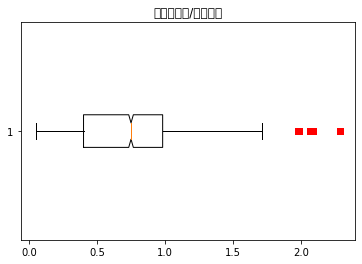

In [ ]:
# box plot
import matplotlib.pyplot as plt
import seaborn as sns

tm_train = train['등록차량수']/train['총세대수']

plt.boxplot(tm_train, notch=1, sym='rs',vert=0)

plt.title('등록차량수/총세대수')
plt.show()


In [ ]:
train.shape

(2904, 16)

In [ ]:
# # 아웃라이어 제거

# def get_outlier(data, weight=1.5):
#     quantile_25 = np.percentile(tm_train.values, 25)
#     quantile_75 = np.percentile(tm_train.values, 75)

#     IQR = quantile_75 - quantile_25
#     IQR_weight = IQR*weight
  
#     lowest = quantile_25 - IQR_weight
#     highest = quantile_75 + IQR_weight
  
#     outlier_idx = tm_train[ (tm_train < lowest) | (tm_train > highest) ].index
#     return outlier_idx


# outlier_idx = get_outlier(train, weight=1.5)
# train.drop(outlier_idx, axis=0, inplace=True)

# # 인덱스 재설정해서 빈 인덱스 채움
# train.reset_index(drop = True, inplace=True)

# train

In [ ]:
tmp_train=train.copy()
tmp_test=test.copy()

In [ ]:
tmp_train['전용면적'] = tmp_train['전용면적']//3*3
tmp_test['전용면적'] = tmp_test['전용면적']//3*3

idx = tmp_train[tmp_train['전용면적']>100].index
tmp_train.loc[idx, '전용면적'] = 100
idx = tmp_test[tmp_test['전용면적']>100].index
tmp_test.loc[idx, '전용면적'] = 100

idx = tmp_train[tmp_train['전용면적']<15].index
tmp_train.loc[idx, '전용면적'] = 15
idx = tmp_test[tmp_test['전용면적']<15].index
tmp_test.loc[idx, '전용면적'] = 15

In [ ]:
def get_total_population(row):
    total_pop = 0
    if row["전용면적"] < 30:
        total_pop += 1 * row["전용면적별세대수"]
    elif row["전용면적"] >= 30 and row["전용면적"] < 39:
        total_pop += 1.5 * row["전용면적별세대수"]
    elif row["전용면적"] >= 39 and row["전용면적"] < 51:
        total_pop += 2 * row["전용면적별세대수"]
    elif row["전용면적"] >= 51 and row["전용면적"] < 57:
        total_pop += 2.5 * row["전용면적별세대수"]
    else:
        total_pop += 3.5 * row["전용면적별세대수"]
    return total_pop

total_pop_arr = []
for i, row in tmp_train.iterrows():
    total_pop_arr.append(get_total_population(row))
train.insert(2, "총구성원수", total_pop_arr)

total_pop_arr = []
for i, row in tmp_test.iterrows():
    total_pop_arr.append(get_total_population(row))
test.insert(2, "총구성원수", total_pop_arr)

In [ ]:
locals = tmp_train["지역"].unique()
locals.sort()
locals_map = dict.fromkeys(locals, 0)
local_weight = [0.5, 0.4, 0.5, 0.6, 0.5, 0.5, 0.5, 0.4, 0.3, 0.5, 0.5, 0.6, 0.5, 0.9, 0.5, 0.5]
for i, local in enumerate(locals_map):
    locals_map[local] = local_weight[i]

est_cars = []
for i, row in tmp_train.iterrows():
    est_cars.append(get_total_population(row) * locals_map[row['지역']])
train.insert(3, "등록차량_인구통계", est_cars)

est_cars = []
for i, row in tmp_test.iterrows():
    est_cars.append(get_total_population(row) * locals_map[row['지역']])
test.insert(3, "등록차량_인구통계", est_cars)

In [ ]:
def get_possible_driver(row):
    driver = 0
    if row["전용면적"] < 30:
        driver += 1 * row["전용면적별세대수"]
    elif row["전용면적"] >= 30 and row["전용면적"] < 39:
        driver += 1.5 * row["전용면적별세대수"]
    elif row["전용면적"] >= 39 and row["전용면적"] < 51:
        driver += 2 * row["전용면적별세대수"]
    else:
        driver += 2.5 * row["전용면적별세대수"]

    return driver

driver_arr = []
for i, row in tmp_train.iterrows():
    driver_arr.append(get_possible_driver(row))
train.insert(4, "운전인원수", driver_arr)

driver_arr = []
for i, row in tmp_test.iterrows():
    driver_arr.append(get_possible_driver(row))
test.insert(4, "운전인원수", driver_arr)

In [ ]:
est_cars = []
for i, row in tmp_train.iterrows():
    est_cars.append(get_possible_driver(row) * row['지역계수'])
train.insert(5, "등록차량_지역통계", est_cars)

est_cars = []
for i, row in tmp_test.iterrows():
    est_cars.append(get_possible_driver(row) * row['지역계수'])
test.insert(5, "등록차량_지역통계", est_cars)

In [ ]:
train

,단지코드,총세대수,총구성원수,등록차량_인구통계,운전인원수,등록차량_지역통계,임대건물구분,지역,지역계수,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,414.0,207.0,414.0,308.551047,아파트,경상남도,0.745292,국민임대,33.48,276,17,A,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,120.0,60.0,120.0,89.435086,아파트,경상남도,0.745292,국민임대,39.60,60,17,A,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,40.0,20.0,40.0,29.811695,아파트,경상남도,0.745292,국민임대,39.60,20,17,A,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,76.0,38.0,76.0,56.642221,아파트,경상남도,0.745292,국민임대,46.90,38,17,A,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,38.0,19.0,38.0,28.321111,아파트,경상남도,0.745292,국민임대,46.90,19,17,A,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,C1036,1254,100.0,40.0,100.0,62.210994,아파트,경기도,0.622110,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2900,C1036,1254,176.0,70.4,176.0,109.491350,아파트,경기도,0.622110,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2901,C1036,1254,60.0,24.0,60.0,37.326596,아파트,경기도,0.622110,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2902,C1036,1254,187.5,75.0,187.5,116.645614,아파트,경기도,0.622110,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,1016,1279


##data transform for model fitting

In [ ]:
train[train['단지코드']=='C1925']['등록차량수'].unique()[0]

75

In [ ]:
test_target = [] 
code = train['단지코드'].unique()
for c in code:
    num = train[train['단지코드']==c]['등록차량수'].unique()[0]
    test_target.append(num)

test_target = pd.DataFrame(test_target)
test_target

,0
0,205
1,1064
2,730
3,553
4,415
...,...
409,57
410,246
411,19
412,16


In [ ]:
############

train = train.iloc[617:,:]
test = train.iloc[:617,:-1]

temp = train.iloc[:617,:]

test_target = [] 
code = temp['단지코드'].unique()
for c in code:
    num = temp[temp['단지코드']==c]['등록차량수'].unique()[0]
    test_target.append(num)

y_test = pd.DataFrame(test_target)


# 인덱스 재설정해서 빈 인덱스 채움
train.reset_index(drop = True, inplace=True)
test.reset_index(drop = True, inplace=True)
y_test.reset_index(drop = True, inplace=True)


In [ ]:
y_test

,0
0,31
1,125
2,177
3,90
4,302
...,...
86,401
87,465
88,669
89,554


In [ ]:
print(train.shape)
test.shape

(2287, 20)


(617, 19)

전용면적별 세대수에 비례해서 단지내주차면수, 등록차량수 변환

In [ ]:
max(train['전용면적'].unique())

248.56

In [ ]:
for i in range(len(test)):
  print(test['전용면적별세대수'][i] / test['총세대수'][i])

0.0022172949002217295
0.0022172949002217295
0.0022172949002217295
0.4878048780487805
0.4878048780487805
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.0024390243902439024
0.11553273427471117
0.38254172015404364
0.306803594351733
0.19127086007702182
0.0012836970474967907
0.0012836970474967907
0.0012836970474967907
0.4900662251655629
0.4900662251655629
0.0026490066225165563
0.0026490066225165563
0.0026490066225165563
0.0026490066225165563
0.0026490066225165563
0.0013245033112582781
0.0013245033112582781
0.0013245033112582781
0.0013245033112582781
0.0013245033112582781
0.6277056277056277
0.2886002886002886
0.0836940836940837
0.751660026560425
0.24833997343957503
0.17670682730923695
0.17670682730923695
0.3614457831325301
0.285140562248996
0.14546640574037834
0.16829745596868884
0.29093281148075667
0.3953033268101761
0.5063291139240507
0.47

In [ ]:
# 전용면적별세대수 비율로 나눠주는 비중 90%
# 전용면적에 비율로 나눠주는 비중 10%

import math

def devide_parking_lots(data, devided_info, p=0.9):
    for col in devided_info:
        temp=[]
        temp2=[]
        for i in range(len(data)):
            if data['임대건물구분'][i] == '아파트':
                temp.append((data[col][i])*p * (data['전용면적별세대수'][i] / data['총세대수'][i]))

                denominator = (data[data['단지코드']==data['단지코드'][i]]['전용면적'] * data[data['단지코드']==data['단지코드'][i]]['전용면적별세대수']).sum()
                numerator = data['전용면적'][i]*data['전용면적별세대수'][i]
                temp2.append((data[col][i])*(1-p)*(numerator/denominator))
            
            elif data['임대건물구분'][i] == '상가':
                # temp.append(math.ceil(data[col][i] * (data['전용면적별세대수'][i] / data['총세대수'][i])))
                temp.append(data[col][i] * (data['전용면적별세대수'][i] / data['총세대수'][i]))
                temp2.append(0)

        print('\n전용면적별세대수 비례 '+str(temp))
        print('전용면적 비례 '+str(temp2))
        target = [x+y for x,y in zip(temp, temp2)]       
        print('합 '+str(target))

        index = data.columns.get_loc(col)
        data.insert(index,col+'_tm',target,True)
        data.drop([col], axis=1, inplace = True)
        
        data.rename(columns={col+'_tm': col}, inplace = True)

devided_info = ['단지내주차면수', '등록차량수']
devide_parking_lots(train, devided_info, 0.95)
devided_info_test = ['단지내주차면수']
devide_parking_lots(test, devided_info_test, 0.95)
train


전용면적별세대수 비례 [0.24168514412416853, 0.24168514412416853, 0.24168514412416853, 55.609756097560975, 55.609756097560975, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 0.2926829268292683, 20.853658536585368, 69.04878048780488, 55.3780487804878, 34.52439024390244, 0.24390243902439024, 0.24390243902439024, 0.24390243902439024, 40.969536423841056, 40.969536423841056, 0.23311258278145697, 0.23311258278145697, 0.23311258278145697, 0.23311258278145697, 0.23311258278145697, 0.11655629139072848, 0.11655629139072848, 0.11655629139072848, 0.11655629139072848, 0.11655629139072848, 289.8116883116883, 133.24675324675323, 38.641558441558445, 487.0005312084993, 160.89946879150065, 67.48433734939759, 67.48433734939759, 138.03614457831324, 108.89518072289155, 179.0982387475538, 207.2078277886497, 358.1964774951076, 486.6974559686888, 63.0126582278481, 58.81181434599156, 0.184

,단지코드,총세대수,총구성원수,등록차량_인구통계,운전인원수,등록차량_지역통계,임대건물구분,지역,지역계수,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C1899,451,1.5,0.75,1.5,1.117939,상가,경상남도,0.745292,임대상가,32.10,1,0,D,NaN,NaN,0.0,4.0,0.241685,0.068736
1,C1899,451,1.5,0.75,1.5,1.117939,상가,경상남도,0.745292,임대상가,32.10,1,0,D,NaN,NaN,0.0,4.0,0.241685,0.068736
2,C1899,451,1.5,0.75,1.5,1.117939,상가,경상남도,0.745292,임대상가,32.10,1,0,D,NaN,NaN,0.0,4.0,0.241685,0.068736
3,C1056,410,200.0,180.00,200.0,163.070433,아파트,제주특별자치도,0.815352,영구임대,26.34,200,0,C,3138000.0,69820.0,0.0,10.0,58.315365,60.745171
4,C1056,410,300.0,270.00,300.0,244.605650,아파트,제주특별자치도,0.815352,영구임대,30.48,200,0,C,3631000.0,80800.0,0.0,10.0,58.740620,61.188145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,C1036,1254,100.0,40.00,100.0,62.210994,아파트,경기도,0.622110,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,40.550475,51.047300
2283,C1036,1254,176.0,70.40,176.0,109.491350,아파트,경기도,0.622110,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,71.368835,89.843248
2284,C1036,1254,60.0,24.00,60.0,37.326596,아파트,경기도,0.622110,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,24.343498,30.645013
2285,C1036,1254,187.5,75.00,187.5,116.645614,아파트,경기도,0.622110,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,61.158018,76.989276


지하철 노선 수, 결측값 처리 후 0 or 1 로 바꿔주기

In [ ]:
# 결측값만 처리

area = ['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시']

def subway(data, area):
    tm = data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].unique()
    na = pd.isna(tm)
    if True in na:
        for a in area:
            data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(pd.Series(np.where(data['지역'] == a, 1,data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])), inplace=True)
    data.fillna(value={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':0}, inplace=True)
subway(train, area)
subway(test, area)

버스 결측값 처리

In [ ]:
# 지역 평균 값으로 결측값 채우기

def bus(data):
    area = train['지역'].unique().tolist()

    for a in area:
        n = np.rint(train[train['지역']==a]['도보 10분거리 내 버스정류장 수'].mean())
        data['도보 10분거리 내 버스정류장 수'].fillna(pd.Series(np.where(data['지역'] == a, n, data['도보 10분거리 내 버스정류장 수'])), inplace=True)


bus(train)
bus(test)

check_Nan = train.isnull()
print(check_Nan.sum())

단지코드                              0
총세대수                              0
총구성원수                             0
등록차량_인구통계                         0
운전인원수                             0
등록차량_지역통계                         0
임대건물구분                            0
지역                                0
지역계수                              0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           169
임대료                             178
도보 10분거리 내 지하철역 수(환승노선 수 반영)      0
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64


임대료 임대보증금 결측값 채우기


In [ ]:
# 임대료 임대보증금 corr가장 큰 전용면적 이용해서 결측값 채움
# 지역별 proportion (임대료/전용면적)의 평균 이용

def rent(data, feature):
    for col in feature:
        area = train['지역'].unique()
        for a in area:
            temp=[]
            for i in train[train['지역']==a].index:
                temp.append(train[col][i] / train['전용면적'][i])
            proportion = np.nanmean(temp)
            print(proportion)
            for i in data[data['지역']==a].index:
                new_rent =  data['전용면적'][i]*proportion

            data[col].fillna(pd.Series(np.where(pd.isnull(data[col]) == True, new_rent, data[col])), inplace=True)

feature = ['임대보증금', '임대료']
rent(train, feature)
rent(test, feature)

# 다시 확인 필요

546674.0953772019
504979.3046031437
584224.5210692013
422306.4601441576
705542.120503266
641959.0326741226
548268.3820744548
379760.1028287338
422122.1474862996
437720.9957623286
736115.2053521812
666968.3825476121
565559.5116974048
547773.2581188923
1665449.5719854878
642104.271809714
3603.0390433814946
3979.104802511025
3609.1964355773216
3945.3738850554573
4959.566980525138
4857.819103908959
3400.793839654307
2994.723690185194
3167.7175948577965
3100.293261095685
5076.446380101928
3672.018959577022
4229.934366956449
5065.1568454064
7166.805873597066
7277.738549758069
568999.5927493396
504979.3046031437
584224.5210692013
422306.4601441576
705542.120503266
641959.0326741226
548268.3820744548
379760.1028287338
422122.1474862996
437720.9957623286
736115.2053521812
666968.3825476121
565559.5116974048
547773.2581188923
1665449.5719854878
642104.271809714
3750.1827243697458
3979.104802511025
3609.1964355773216
3945.3738850554573
4959.566980525138
4857.819103908959
3400.793839654307
2994.72

mapping

In [ ]:
# 지역

local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i

train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)

In [ ]:
# 임대건물구분

local_map = {}
for i, loc in enumerate(train['임대건물구분'].unique()):
    local_map[loc] = i

train['임대건물구분'] = train['임대건물구분'].map(local_map)
test['임대건물구분'] = test['임대건물구분'].map(local_map)


In [ ]:
local_map = {}
for i, loc in enumerate(train['공급유형'].unique()):
    local_map[loc] = i

train['공급유형'] = train['공급유형'].map(local_map)
test['공급유형'] = test['공급유형'].map(local_map)


In [ ]:
local_map = {}
for i, loc in enumerate(train['자격유형'].unique()):
    local_map[loc] = i

train['자격유형'] = train['자격유형'].map(local_map)
test['자격유형'] = test['자격유형'].map(local_map)


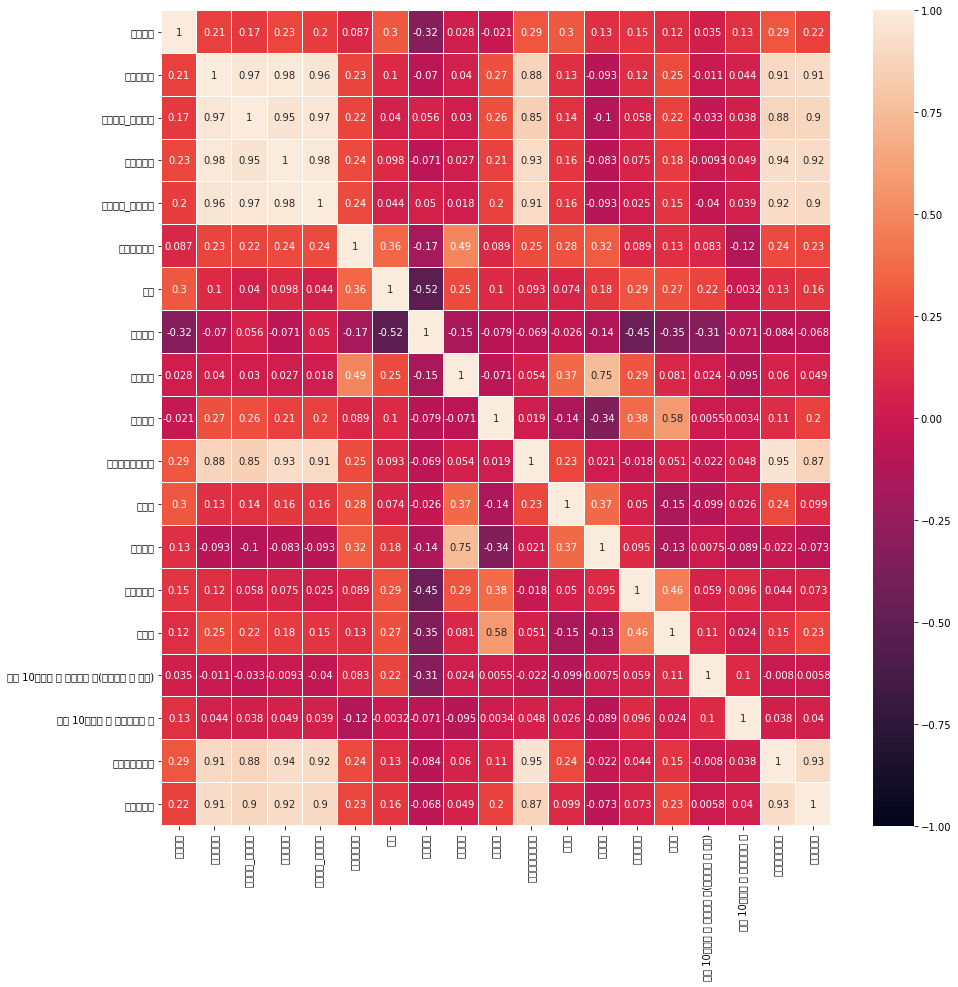

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.01)

In [ ]:
train.columns

Index(['단지코드', '총세대수', '총구성원수', '등록차량_인구통계', '운전인원수', '등록차량_지역통계', '임대건물구분',
       '지역', '지역계수', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수',
       '등록차량수'],
      dtype='object')

## column 제거

In [ ]:
col = ['단지코드', '임대건물구분',
       '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', '임대료',
       '단지내주차면수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '등록차량수']

train_new = train[col]
test_new = test[col[:-1]]


결측값 처리

In [ ]:
x_train = train_new.iloc[:, 1:-1]
y_train = train_new.iloc[:,-1]
x_test = test_new.iloc[:,1:]

##scaling


In [ ]:
# Scaling

import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
    )

class ScalingFactor:
    def __init__(self, scaler, features):
        self.scaler = scaler
        self.features = features

def scaling(data, scaler, features):

    temp = data.copy()

    target_cols = features
    temp = temp[target_cols]
    
    scaler.fit(temp)

    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data

def preprocess_data(data, scale_factors):
    
    temp = data.copy()

    for factor in scale_factors:
        temp = scaling(temp, factor.scaler, factor.features)

    return temp

In [ ]:
scale_factors = []

features_selected = x_train.columns.tolist()

scale_factors.append(ScalingFactor(MinMaxScaler(), features_selected))
scale_factors.append(ScalingFactor(StandardScaler(), features_selected))


x_train = preprocess_data(x_train, scale_factors)
x_test = preprocess_data(x_test, scale_factors)


print(x_train.shape)
print(x_test.shape)
print(x_train)

(2287, 12)
(617, 12)
        임대건물구분        지역  ...  도보 10분거리 내 지하철역 수(환승노선 수 반영)  도보 10분거리 내 버스정류장 수
0    -3.774476 -1.624470  ...                     -0.313205            0.094531
1    -3.774476 -1.624470  ...                     -0.313205            0.094531
2    -3.774476 -1.624470  ...                     -0.313205            0.094531
3     0.264937 -1.393024  ...                     -0.313205            2.285660
4     0.264937 -1.393024  ...                     -0.313205            2.285660
...        ...       ...  ...                           ...                 ...
2282  0.264937  0.689985  ...                     -0.313205           -0.270658
2283  0.264937  0.689985  ...                     -0.313205           -0.270658
2284  0.264937  0.689985  ...                     -0.313205           -0.270658
2285  0.264937  0.689985  ...                     -0.313205           -0.270658
2286  0.264937  0.689985  ...                     -0.313205           -0.270658

[2287 rows x 12 co

feature selection

임대건물구분>>> 0 : 0.236634
지역>>> 1 : 0.195933
공급유형>>> 2 : 0.310238
전용면적>>> 3 : 0.296875
전용면적별세대수>>> 4 : 1.393551
공가수>>> 5 : 0.299778
자격유형>>> 6 : 0.290351
임대보증금>>> 7 : 0.229201
임대료>>> 8 : 0.249680
단지내주차면수>>> 9 : 1.742760
도보 10분거리 내 지하철역 수(환승노선 수 반영)>>> 10 : 0.010186
도보 10분거리 내 버스정류장 수>>> 11 : 0.177798


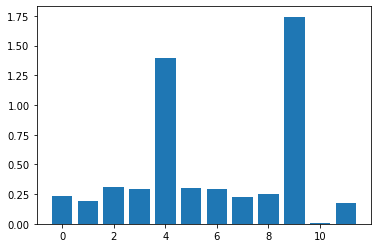

In [ ]:
# features' correlation with target

#Correlation Feature Selection
#Mutual Information Feature Selection

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot

def select_features(data, target):
    # configure to select all features
    # fs = SelectKBest(score_func=f_regression, k='all')
    fs = SelectKBest(score_func=mutual_info_regression, k='all')

    # learn relationship from training data
    fs.fit(data, target)
    # transform train input data
    train_transformed = fs.transform(data)

    return train_transformed, fs


# feature selection
train_transformed, fs = select_features(x_train, y_train)
# what are scores for the features

for i in range(len(fs.scores_)):
    print(x_train.columns[i]+'>>> %d : %f' % (i, fs.scores_[i]))
    # plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()


In [ ]:
len(x_train.columns)

12

In [ ]:
# # find optimized features

# # compare different numbers of features selected using mutual information

# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_regression
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.feature_selection import f_regression
# from sklearn.ensemble import RandomForestRegressor
# # from lightgbm import LGBMRegressor

# from sklearn.pipeline import Pipeline
# from matplotlib import pyplot


# # define number of features to evaluate
# num_features = [i for i in range(1, len(x_train.columns)+1)]

# # enumerate each number of features
# results = []
# scores_mean = []

# model_feature_selection = mutual_info_regression
# # model_feature_selection = f_regression

# for k in num_features:
#     # create pipeline
#     # model = LGBMRegressor()
#     model = RandomForestRegressor(n_jobs=-1, random_state=42)
#     fs = SelectKBest(score_func=model_feature_selection, k=k)
#     # fs = SelectKBest(score_func=f_regression, k=k)

#     pipe = Pipeline(steps=[('sel',fs), ('lr', model)])
#     # evaluate the model
#     cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)
#     scores = cross_val_score(pipe, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#     results.append(scores)
#     scores_mean.append(mean(scores))

#     print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))

# # print(results)
# print(scores_mean)

In [ ]:
# # print index which means the most appropriate number of features

# max_value = None
# max_idx = None

# for idx, num in enumerate(scores_mean):
#     if (max_value is None or num > max_value):
#         max_value = num
#         max_idx = idx

# print('Maximum value:', max_value, "At index: ", max_idx)
# print('\nOptimized number of features : ' +str(max_idx+1)) 

In [ ]:
# # feature selection

# def select_features(data, target, test):
#     # configure to select all features
#     # fs = SelectKBest(score_func=f_regression, k='all')
#     fs = SelectKBest(score_func=model_feature_selection, k=max_idx+1)

#     # learn relationship from training data
#     fs.fit(data, target)
#     # transform train input data
#     train_selected = fs.transform(data)
    
#     all_features = data.columns
#     # print(all_features)
    
#     selected_mask = fs.get_support()

#     selected_features = all_features[selected_mask]
#     unselected_features = all_features[~selected_mask]
#     print(selected_features)

#     train_selected = pd.DataFrame(train_selected)
#     train_selected.columns = selected_features
#     # print(train_selected.columns)
    
#     test.drop(unselected_features, axis=1, inplace=True)
    
#     return train_selected, fs
 
# # feature selection
# x_train, fs = select_features(x_train, y_train, x_test)

# # plot model performance for comparison

# pyplot.figure(figsize=(20,15))
# pyplot.boxplot(results, labels=num_features, showmeans=True)
# pyplot.show()

# # print(results)
# # print(x_train)
# # print(x_test)

In [ ]:
# feature selection

def select_features(data, target, test, k):

    # model_fs = f_regression
    model_fs = mutual_info_regression

    fs = SelectKBest(score_func=model_fs, k=k)

    # learn relationship from training data
    fs.fit(data, target)
    # transform train input data
    train_selected = fs.transform(data)
    
    all_features = data.columns
    # print(all_features)
    
    selected_mask = fs.get_support()

    selected_features = all_features[selected_mask]
    unselected_features = all_features[~selected_mask]
    print(selected_features)

    train_selected = pd.DataFrame(train_selected)
    train_selected.columns = selected_features
    # print(train_selected.columns)
    
    test.drop(unselected_features, axis=1, inplace=True)
    
    return train_selected, fs
 
# feature selection
x_train, fs = select_features(x_train, y_train, x_test, len(x_train.columns))


Index(['임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금',
       '임대료', '단지내주차면수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수'],
      dtype='object')


train_test_split 

In [ ]:
from sklearn.model_selection import train_test_split
random_seed = 42

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.26, 
                                                      random_state=random_seed,shuffle=True)

##model fitting

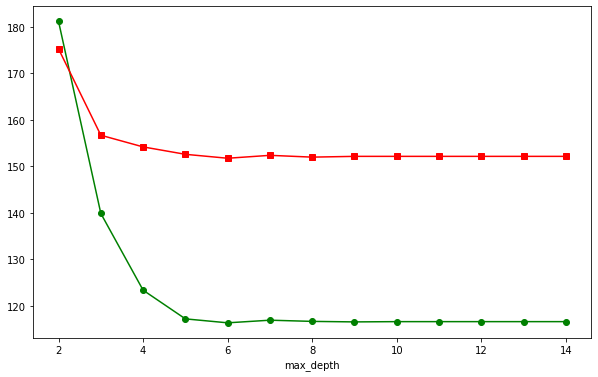

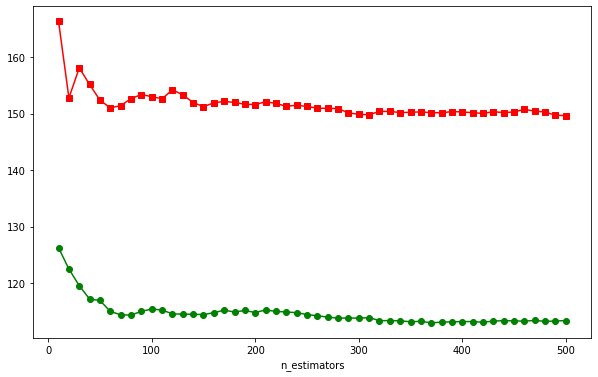

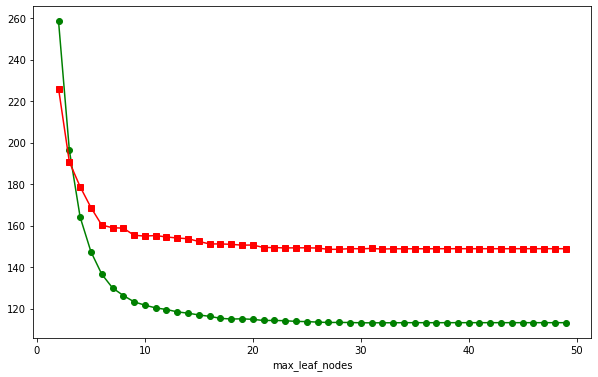

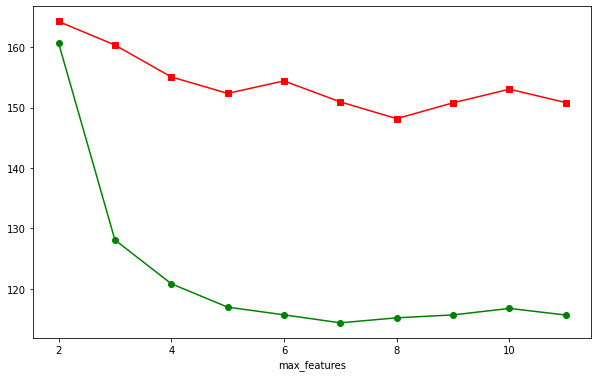

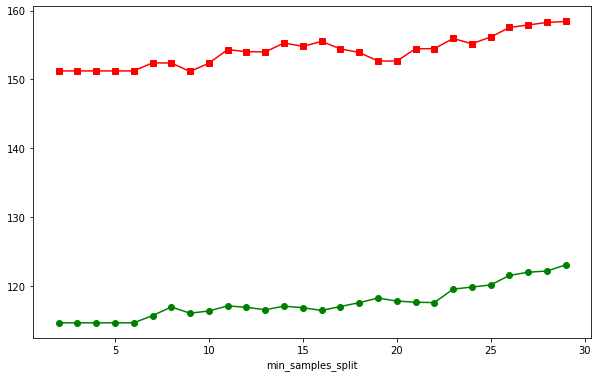

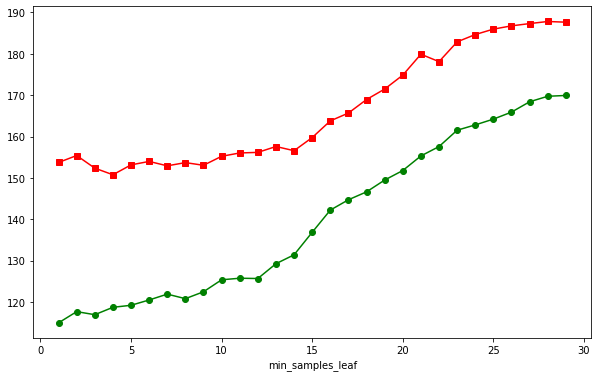

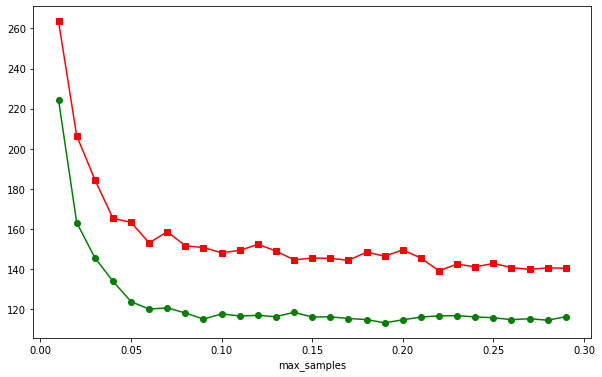

In [ ]:
from sklearn.ensemble import RandomForestRegressor


# Score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def Score(model, Y_test, pred):
    
    return mean_absolute_error(Y_test, pred) 


params = {'max_depth':[i for i in range(2,15)], 
          'n_estimators':[i for i in range(10,510,10)], 
          'max_leaf_nodes':[i for i in range(2,50)], 
          'max_features':[i for i in range(2,len(x_train.columns))], 
          'min_samples_split':[i for i in range(2,30)], 
          'min_samples_leaf':[i for i in range(1,30)], 
          'max_samples':[i for i in np.arange(0.01, 0.3, 0.01)]}

k=1
for param, ranges in params.items():
    scores_train = []
    scores_test = []
    for num in ranges:
        mod = RandomForestRegressor(n_jobs=-1, random_state=42, criterion='mae', verbose=0,
                              max_depth=7, n_estimators = 200, bootstrap=True,
                              max_leaf_nodes=15, max_features=8, min_samples_split=8,
                              min_samples_leaf=3, max_samples=0.22
                              )
        mod.set_params(**{param:num})

        mod.fit(X_train, Y_train)
        pred_train = mod.predict(X_test)
        pred_test = mod.predict(x_test)
        pred_test = np.rint(pred_test)

        code = test['단지코드'].unique()
        num_of_code = []

        for c in code:
            num_of_code.append(len(test[test['단지코드'] == c]))

        pred_testset = []
        pred_list = pred_test.tolist()

        for n in num_of_code:
            num = 0
            for j in range(n):
                num += pred_list.pop(0)

            pred_testset.append(num)


        scores_train.append(Score(mod, Y_test, pred_train)*len(Y_test)/len(y_test))
        scores_test.append(Score(mod, y_test, pred_testset))

    plt.figure(figsize=(10,50))
    plt.subplot(7,1,k)
    plt.xlabel(param)
    plt.plot(ranges, scores_train, color='green', marker='o')
    plt.plot(ranges, scores_test, color='red', marker='s')
    plt.show
    k += 1





In [ ]:
print(len(Y_test))
print(len(y_test))

595
91


##model

In [ ]:
# 참고 https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/ 
# https://stackoverflow.com/questions/32965188/scikit-set-params